# Predicting Attendance to a Test Preparation Course Based on Candidates' Scores

## Introduction 

Test preparation courses are a form of shadow education, which is referred to as "educational activities, such as tutoring and extra classes,
occurring outside of the formal channels of an educational system" (Buchmann et al., 436) and are used with the intention of increasing students' chances of success in high school courses and gaining admission into the post-secondary institute of their choice. A few companies offering these courses are confident their services are effective, and go as far as to offer a return of clients' money if a high score is not achieved (Buchmann et al., 440). 

Predictive Question: Can we use the exam scores of students to predict whether they attended a test preparation course?

The `all_exams.csv` data set is used to determine whether a student took a test prep course. Their exam scores from math, reading, and writing (**Note that when we start Performing KNN Classification we only used math and reading exam scores as our predictors because more then that was causing the kernal to die and analysis to be slow**)  would identify if they attended a test prep course. The data set also contains information about high school students from the US, and includes the students’ gender, race/ethnicity, parental level of education, and lunch access. The size of the sample was increased to 1200 by combining the downloaded data, since the data is generated spontaneously. By doing this, we expect our model to have a higher accuracy because it will be able to gain familiarity with more data examples.

## Methods

In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Loading the Data

In [2]:
options(repr.matrix.max.rows = 10)
all_exams<-read_csv("https://raw.githubusercontent.com/SopTes27/group26_project/main/GP_data/all_exams.csv")
all_exams

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  gender = col_character(),
  `race/ethnicity` = col_character(),
  `parental level of education` = col_character(),
  lunch = col_character(),
  `test preparation course` = col_character(),
  `math score` = col_double(),
  `reading score` = col_double(),
  `writing score` = col_double()
)



X1,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,male,group D,some college,standard,none,69,63,62
2,female,group E,bachelor's degree,free/reduced,completed,65,78,80
3,female,group C,some high school,standard,none,57,56,59
4,female,group D,associate's degree,free/reduced,none,62,73,71
5,male,group C,some college,free/reduced,none,46,52,46
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1196,male,group C,associate's degree,standard,completed,65,63,62
1197,female,group C,some high school,standard,none,69,74,68
1198,female,group D,some college,free/reduced,none,43,48,45


### Wrangling and Cleaning the Data

We remove the X1 column that will not be used in our model from the original data set. Then, we make the gender, race/ethnicity, parental level of education, lunch, and test preparation course columns as category data types.

In [3]:
colnames(all_exams)<-c("X1", "gender", "race_ethnicity", "parental_level_of_education",
"lunch", "test_preparation_course", "math_score", "reading_score", "writing_score")

tidying_data <-select(all_exams, gender:writing_score)%>%
    mutate(across(gender:test_preparation_course, as.factor))
tidying_data

gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
male,group D,some college,standard,none,69,63,62
female,group E,bachelor's degree,free/reduced,completed,65,78,80
female,group C,some high school,standard,none,57,56,59
female,group D,associate's degree,free/reduced,none,62,73,71
male,group C,some college,free/reduced,none,46,52,46
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
male,group C,associate's degree,standard,completed,65,63,62
female,group C,some high school,standard,none,69,74,68
female,group D,some college,free/reduced,none,43,48,45


Use `tidying_data` dataset created in the previous step, create a new column in the dataset called `avg_grade` by grouping the test_preparation_course, math_score, reading_score, and writing_score and calculating the average grade. The new dataset created is named `exams_data`. The new average grade column represents the mean of students' combined math, reading, and writing scores. The average grade will be used as a predictor in the data analysis performed later on. 

In [4]:
exams_data<-tidying_data %>%
    rowwise(math_score:writing_score)%>%
    mutate(avg_grade=mean(math_score:writing_score))%>%
    select(test_preparation_course, math_score, reading_score, writing_score, avg_grade)
exams_data

test_preparation_course,math_score,reading_score,writing_score,avg_grade
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
none,69,63,62,65.5
completed,65,78,80,72.5
none,57,56,59,58.0
none,62,73,71,66.5
none,46,52,46,46.0
⋮,⋮,⋮,⋮,⋮
completed,65,63,62,63.5
none,69,74,68,68.5
none,43,48,45,44.0


The `exams_data` dataset is split into a training set and a testing set. The training set will contain 75% of the dataset, and be named `exam_train`. The testing set will contain 25% of the data from `exams_data`, and will be named `exam_test`. The seed is also set to 2021.

In [5]:
set.seed(2021)

data_split <- initial_split(exams_data, prop = 0.75, strata = test_preparation_course)
exam_train <- training(data_split)
exam_test <- testing(data_split)

glimpse(exam_train)

Rows: 901
Columns: 5
Rowwise: math_score, reading_score, writing_score
$ test_preparation_course <fct> none, completed, none, none, none, none, none…
$ math_score              <dbl> 69, 65, 57, 62, 46, 39, 78, 57, 80, 85, 79, 5…
$ reading_score           <dbl> 63, 78, 56, 73, 52, 35, 90, 62, 86, 86, 75, 4…
$ writing_score           <dbl> 62, 80, 59, 71, 46, 28, 84, 54, 91, 84, 71, 3…
$ avg_grade               <dbl> 65.5, 72.5, 58.0, 66.5, 46.0, 33.5, 81.0, 55.…


### Exploratory Data Analysis - Creating a Summary and Visualization of the `exams_data` Dataset

First, the training and testing datasets were examined for any missing values. 

In [6]:
sum(is.na(exam_train))

[1] 0

In [7]:
sum(is.na(exam_test))

[1] 0

Next, we check the number of observations in both the training and testing datasets. This is performed to determine whether there is a class imbalance present in the data before upsampling. From Table ?? and Table ?? below, we can conclude that there is a class imbalance present in the training data, because students who did not take the test preparation course were more common than those who did. 

In [8]:
num_obs_train <- nrow(exam_train)
exam_train %>%
  group_by(test_preparation_course) %>%
  summarize(
    count = n(), 
    percentage = n() / num_obs_train 
  )

`summarise()` ungrouping output (override with `.groups` argument)



test_preparation_course,count,percentage
<fct>,<int>,<dbl>
completed,309,0.3429523
none,592,0.6570477


In [9]:
num_obs_test <- nrow(exam_test)
exam_test %>%
    group_by(test_preparation_course)%>%
    summarize(
        count = n(), 
        percentage = n() / num_obs_train
    )

`summarise()` ungrouping output (override with `.groups` argument)



test_preparation_course,count,percentage
<fct>,<int>,<dbl>
completed,102,0.1132075
none,197,0.2186459


Due to the class imbalance in the training data, upsampling is conducted on only the training dataset to balance the data, as shown below.

In [10]:
exam_recipe <- recipe(test_preparation_course ~ ., data = exam_train)%>% 
  step_upsample(test_preparation_course, over_ratio = 1, skip = FALSE)%>%
  prep() 
exam_recipe

upsampled_exam <- bake(exam_recipe, exam_train)

upsampled_exam %>%
  group_by(test_preparation_course) %>%
  summarize(n = n())
upsampled_exam

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Training data contained 901 data points and no missing data.

Operations:

Up-sampling based on test_preparation_course [trained]

`summarise()` ungrouping output (override with `.groups` argument)



test_preparation_course,n
<fct>,<int>
completed,592
none,592


math_score,reading_score,writing_score,avg_grade,test_preparation_course
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
80,79,77,78.5,completed
79,71,70,74.5,completed
77,82,87,82.0,completed
41,53,49,45.0,completed
83,66,70,76.5,completed
⋮,⋮,⋮,⋮,⋮
73,70,71,72,none
56,66,62,59,none
58,57,58,58,none


Table ? below summarizes the values of the predictor variables in the training set which will be used later on in our data analysis.

In [64]:
predictor_means <- exam_train%>%
    group_by(test_preparation_course)%>%
    summarize(
        math_score_average=mean(math_score),
        writing_score_average=mean(writing_score),
        reading_score_average=mean(reading_score),
        total_average_score=mean(avg_grade)
    )
predictor_means

`summarise()` ungrouping output (override with `.groups` argument)



test_preparation_course,math_score_average,writing_score_average,reading_score_average,total_average_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
completed,70.89644,75.24272,74.23301,73.06958
none,64.98480,64.67399,66.88514,64.82939


Finally, Table ??? summarizes all of the data present in the training data set.

In [12]:
summary(exam_train) 
do.call(cbind, lapply(exam_train, summary))

 test_preparation_course   math_score     reading_score    writing_score  
 completed:309           Min.   : 14.00   Min.   : 15.00   Min.   : 13.0  
 none     :592           1st Qu.: 56.00   1st Qu.: 59.00   1st Qu.: 58.0  
                         Median : 67.00   Median : 69.00   Median : 68.0  
                         Mean   : 67.01   Mean   : 69.41   Mean   : 68.3  
                         3rd Qu.: 78.00   3rd Qu.: 80.00   3rd Qu.: 79.0  
                         Max.   :100.00   Max.   :100.00   Max.   :100.0  
   avg_grade     
 Min.   : 16.50  
 1st Qu.: 57.50  
 Median : 67.50  
 Mean   : 67.66  
 3rd Qu.: 79.00  
 Max.   :100.00  

,test_preparation_course,math_score,reading_score,writing_score,avg_grade
Min.,309,14.00000,15.00000,13.00000,16.50000
1st Qu.,592,56.00000,59.00000,58.00000,57.50000
Median,309,67.00000,69.00000,68.00000,67.50000
Mean,592,67.01221,69.40511,68.29856,67.65538
3rd Qu.,309,78.00000,80.00000,79.00000,79.00000
Max.,592,100.00000,100.00000,100.00000,100.00000


The final step of the exploratory data analysis was to create a visualization representing the relationship that each predictor variable had with each other. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



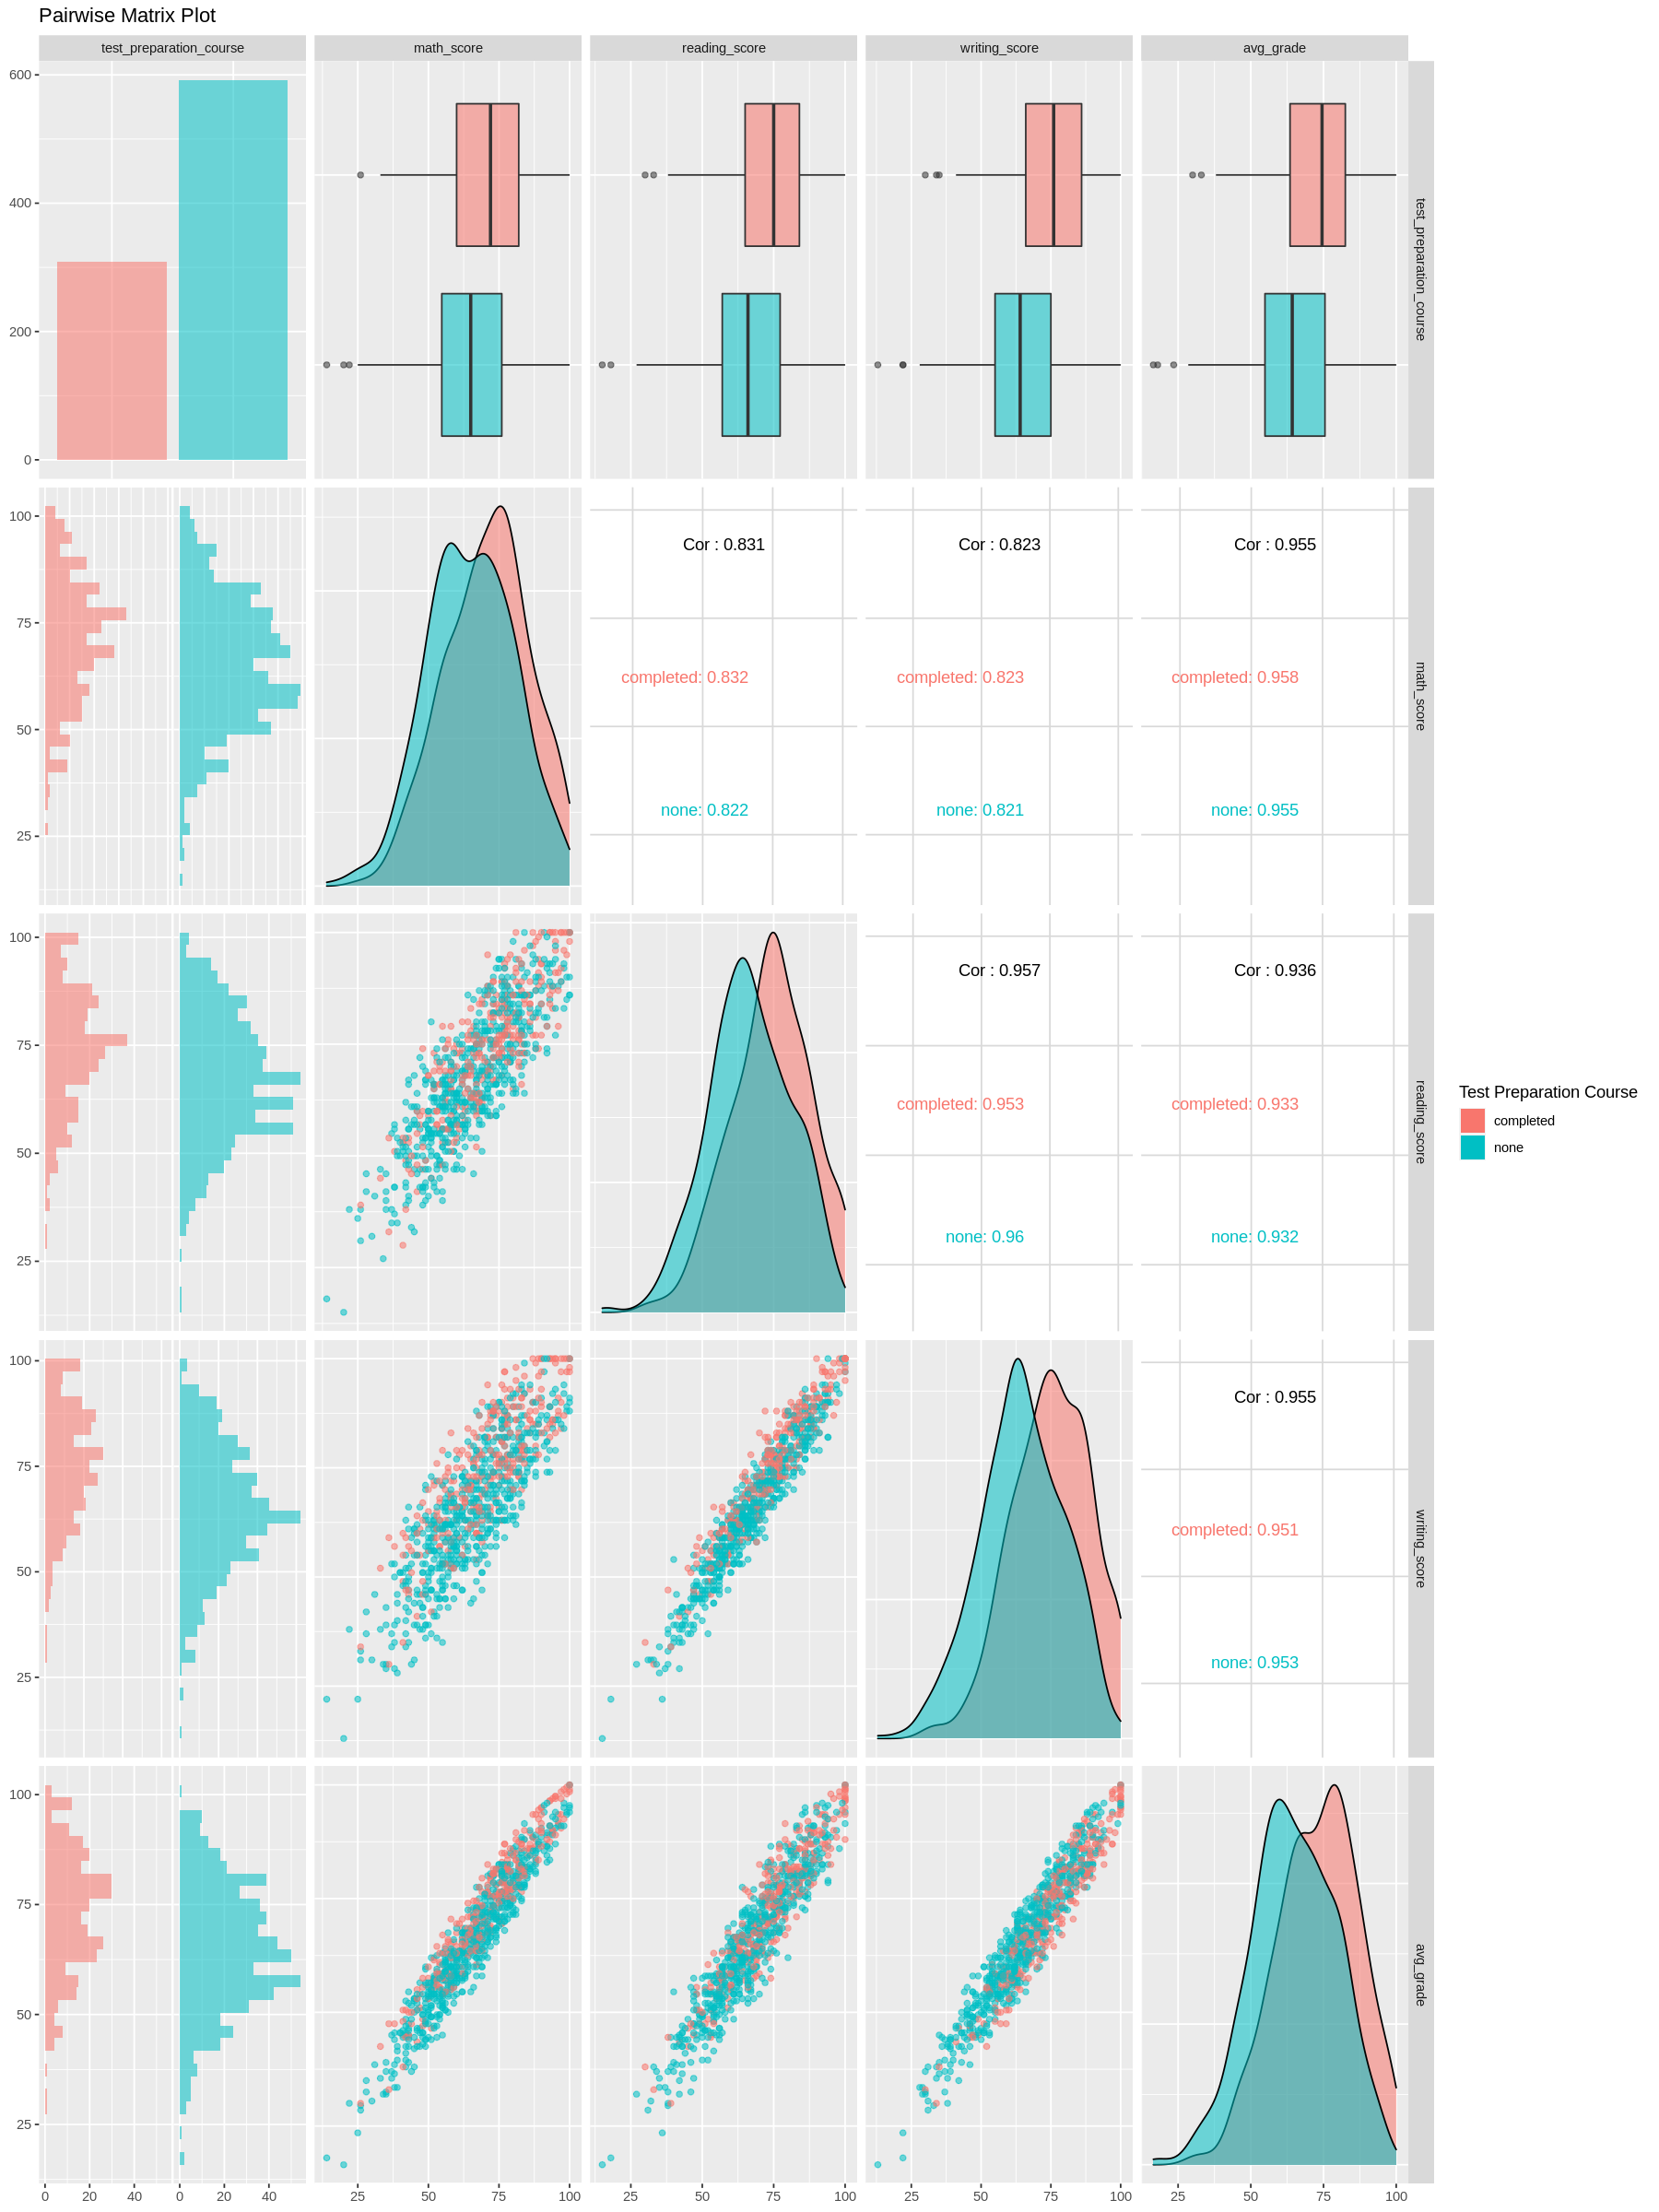

In [14]:
options(repr.plot.width = 15, repr.plot.height = 20) 
predictor_plots <-ggplot(exam_train, aes(x=test_preparation_course, fill=test_preparation_course))+
geom_bar()+
labs(fill="Test Preparation Course")+
ggtitle("Predictors Pairwise Matrix Plot")

bar_legend<-grab_legend(predictor_plots)

Pairwise_Matrix_legend<- ggpairs(exam_train, title = "Pairwise Matrix Plot", legend = bar_legend,
                           aes(alpha = 0.2, color = test_preparation_course))+
labs(fill="Test Preparation Course")
Pairwise_Matrix_legend

### Data Analysis - Performing KNN Classification

Before scaling and centering the data, a 5-fold cross-validation is performed to tune the hyperparameters. The strata argument is set as our categorical target variable, which is the `test_preparation_course`.

In [15]:
exam_vfold <- vfold_cv(exam_train, v = 5, strata = test_preparation_course)

To create our KNN classification model, we will first create a recipe using the training data. The recipe specifies the target variable (test_preparation_course) and the predictors, and also scales and centers the predictors.

### Having more the 2 predictor varibles was causing the kernal to die and making the code run for a long time. So we decided to use just `math_score`  `reading_score` as our predictor varibles while preforming KNN classification. This will also make it easier to visulize results.

In [63]:
# exam_recipe <- recipe(test_preparation_course ~ ., data = exam_train) %>%
#                 step_scale(all_predictors()) %>%
#                 step_center(all_predictors())
# exam_recipe

exam_recipe <- recipe(test_preparation_course ~math_score+ reading_score, data = exam_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
exam_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we created the K-nearest neighbors classifier and tuned each parameter in the model. In the next code block, cross validation is used to evaluate the the accuracy of the classifier.

In [17]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Then, we created a dataframe named `k_vals` that has a sequence of K values between 1 and 20 we would like to test out. This new argument is passed through the grid argument of the `tune_grid` function.

In [18]:
k_vals <- tibble(neighbors = seq(from = 1, to = 50))
knn_results <- workflow() %>%
       add_recipe(exam_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = exam_vfold, grid = k_vals) %>%
       collect_metrics()

accuracies <- knn_results %>% 
       filter(.metric == "accuracy" )
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5860291,5,0.010443528,Model01
2,accuracy,binary,0.5937886,5,0.008389807,Model02
3,accuracy,binary,0.5927146,5,0.008165114,Model03
4,accuracy,binary,0.6027208,5,0.011958726,Model04
5,accuracy,binary,0.6182334,5,0.012534168,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
46,accuracy,binary,0.6481785,5,0.006035172,Model46
47,accuracy,binary,0.6525984,5,0.008040925,Model47
48,accuracy,binary,0.6537095,5,0.008027921,Model48


As the last step of our KNN classification model, we plotted a visualization of the accuracy versus K value to deduce which K value would be the best. From the plot below, k = 28 would be the best value because it has the highest accuracy on the graph, and we can see that values neighbouring 28 do not have any dramatic changes in accuracy . And we confirmed that by arranging the means of the k values from greatest to smallest confirming the k=28 has the greatest accuracy.

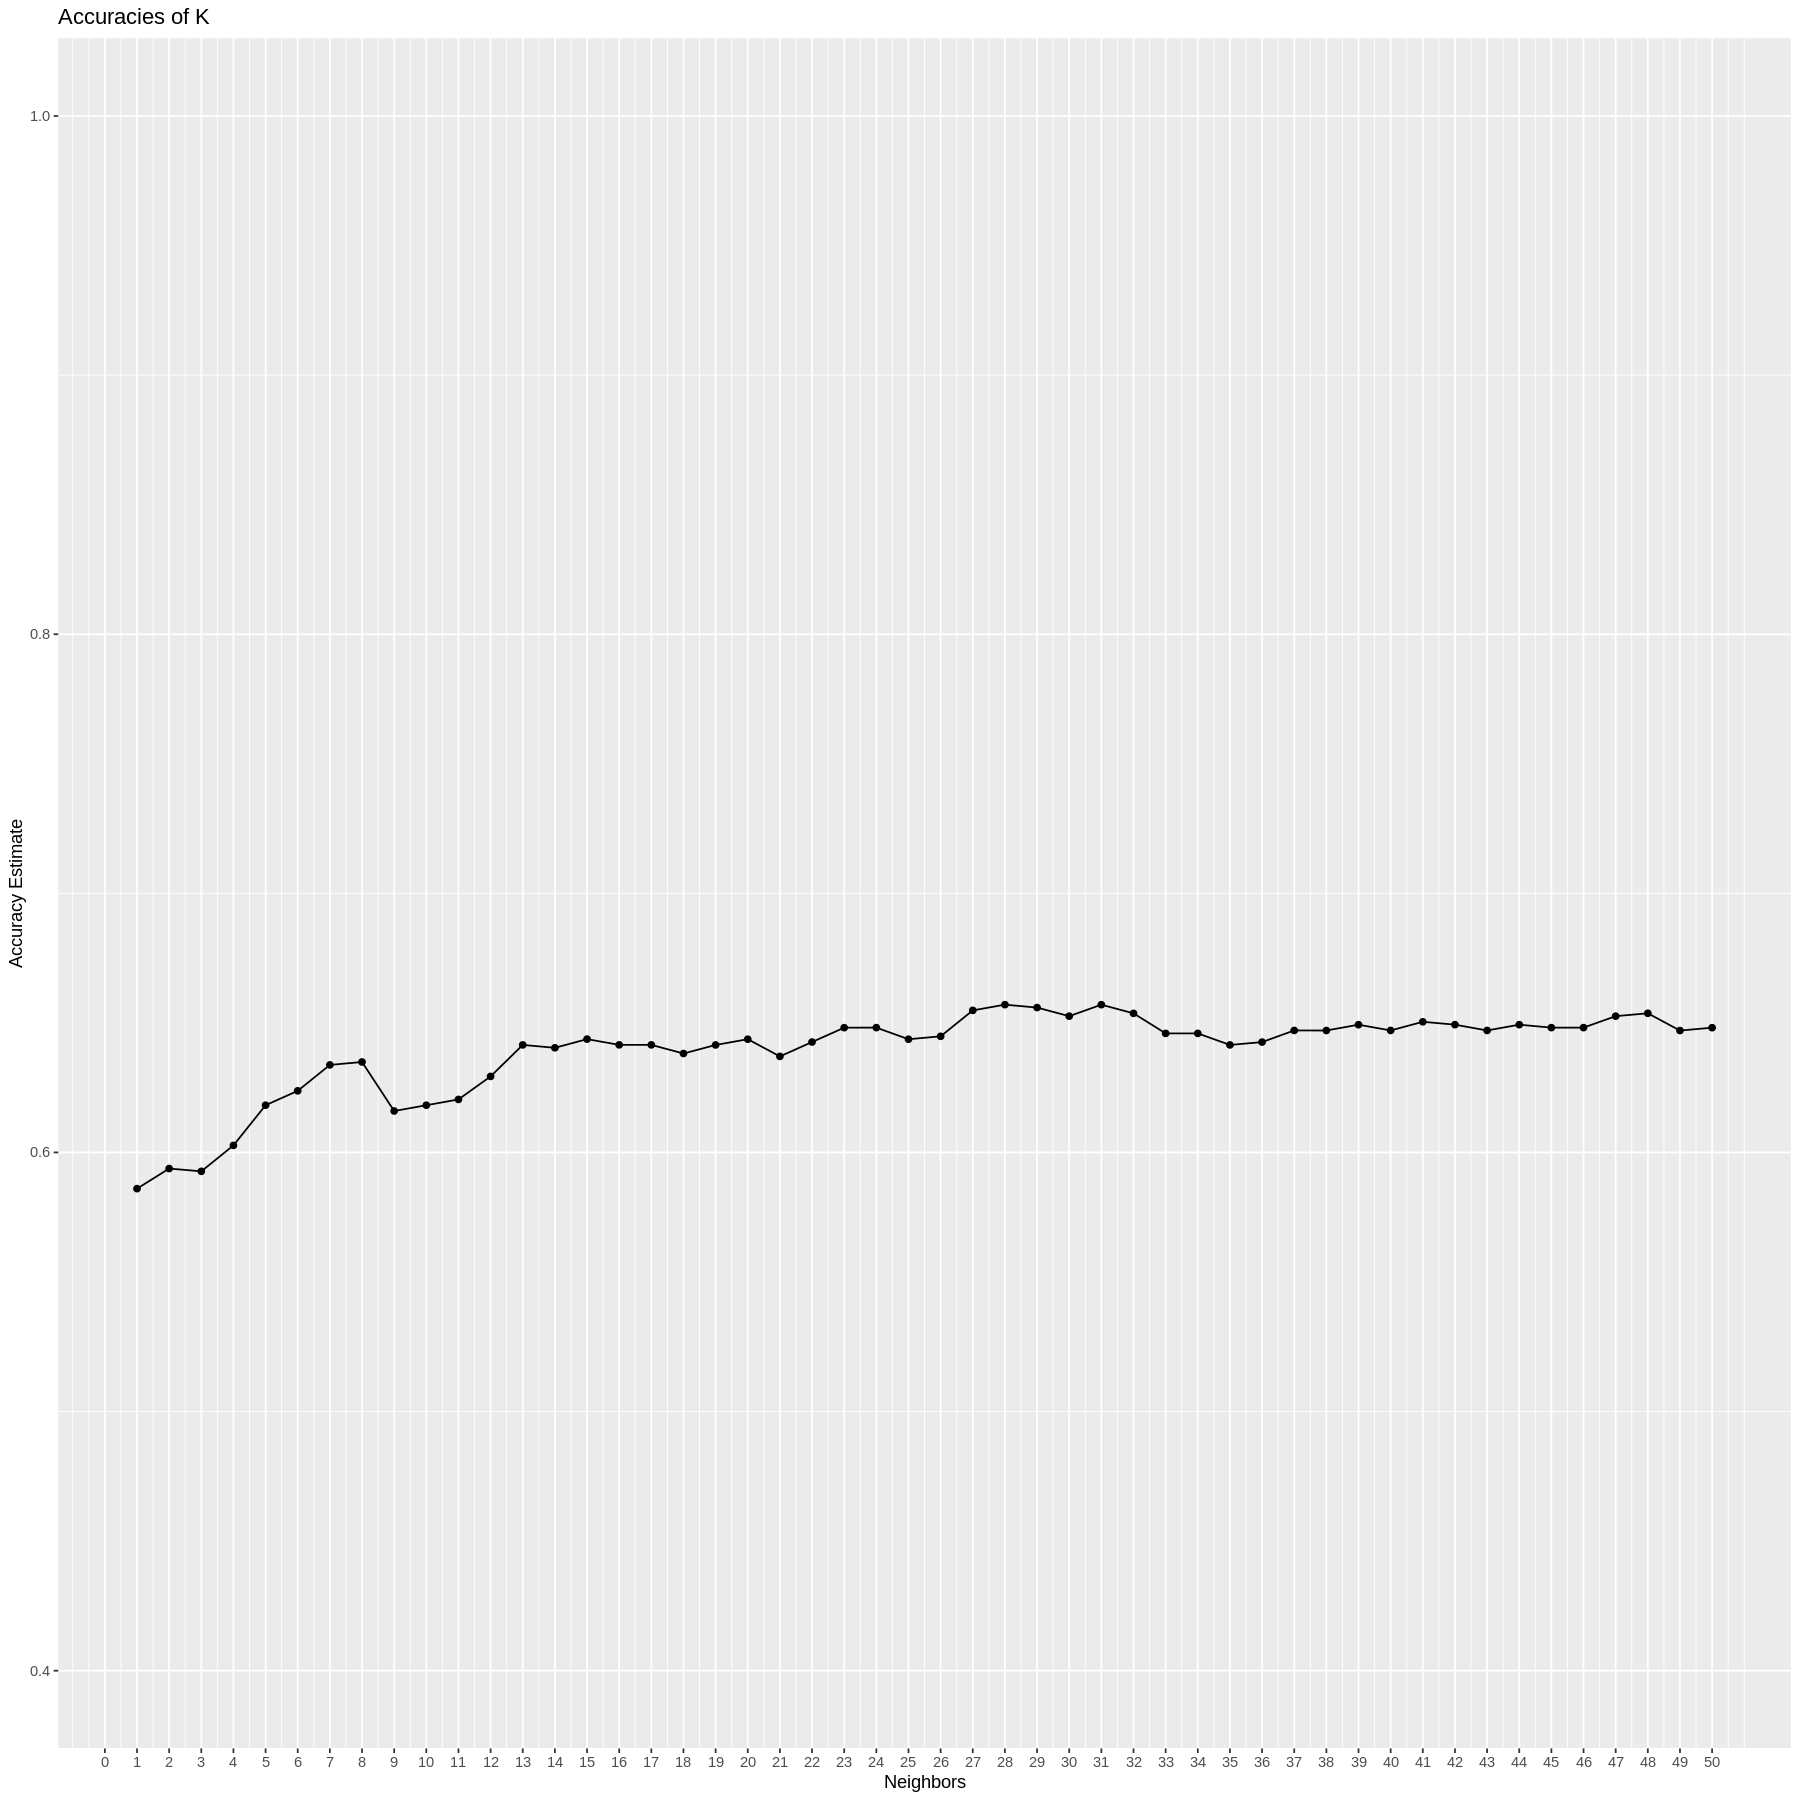

In [65]:
options(repr.plot.width=15, repr.plot.height=15)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) +
ggtitle("Accuracies of K")
accuracy_versus_k

In [20]:
best_k<-accuracies%>%arrange(desc(mean)) 
head(best_k)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
28,accuracy,binary,0.6570367,5,0.005792841,Model28
31,accuracy,binary,0.6570244,5,0.005980131,Model31
29,accuracy,binary,0.6559134,5,0.006124982,Model29
27,accuracy,binary,0.6548268,5,0.006162367,Model27
48,accuracy,binary,0.6537095,5,0.008027921,Model48
32,accuracy,binary,0.6536849,5,0.004754579,Model32


In [22]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 28) %>%
  set_engine("kknn") %>%
  set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 28
  weight_func = rectangular

Computational engine: kknn 


In [23]:
knn_fit <- knn_spec %>%
  fit(test_preparation_course ~math_score+ reading_score , data = exam_train)

### Visualization of the Data Analysis

To visualize our data analysis, we plotted a decision boundary graphs. `Decision Boundaries` graph, has the math score on the x-axis versus the reading score on the y-axis. The blue and organe clouds indicate what classification a point would be given if it were to lie within it.  **This visualizations can be used to...**

In [49]:
math_grid <- seq(min(exam_train $ math_score), 
                max(exam_train $ math_score), 
                length.out = 100)
# wri_grid <- seq(min(exam_train $ writing_score), 
#                 max(exam_train $ writing_score), 
#                 length.out = 100)
read_grid <- seq(min(exam_train $ reading_score), 
                max(exam_train $ reading_score), 
                length.out = 100)
# avg_grid <- seq(min(exam_train$avg_grade), 
#                 max(exam_train$avg_grade), 
#                 length.out = 100)




In [56]:
asgrid <- as_tibble(expand.grid(math_score = math_grid, 
                                #writing_score = wri_grid,
                                reading_score = read_grid
                                #avg_grade = avg_grid
                               ))

In [55]:
#double check the code 
knnPredGrid <- predict(knn_fit, asgrid)%>%
bind_cols(asgrid)%>%
rename(test_preparation_course = .pred_class)
knnPredGrid


test_preparation_course,math_score,reading_score
<fct>,<dbl>,<dbl>
none,14.00000,15
none,14.86869,15
none,15.73737,15
none,16.60606,15
none,17.47475,15
⋮,⋮,⋮
completed,96.52525,100
completed,97.39394,100
completed,98.26263,100


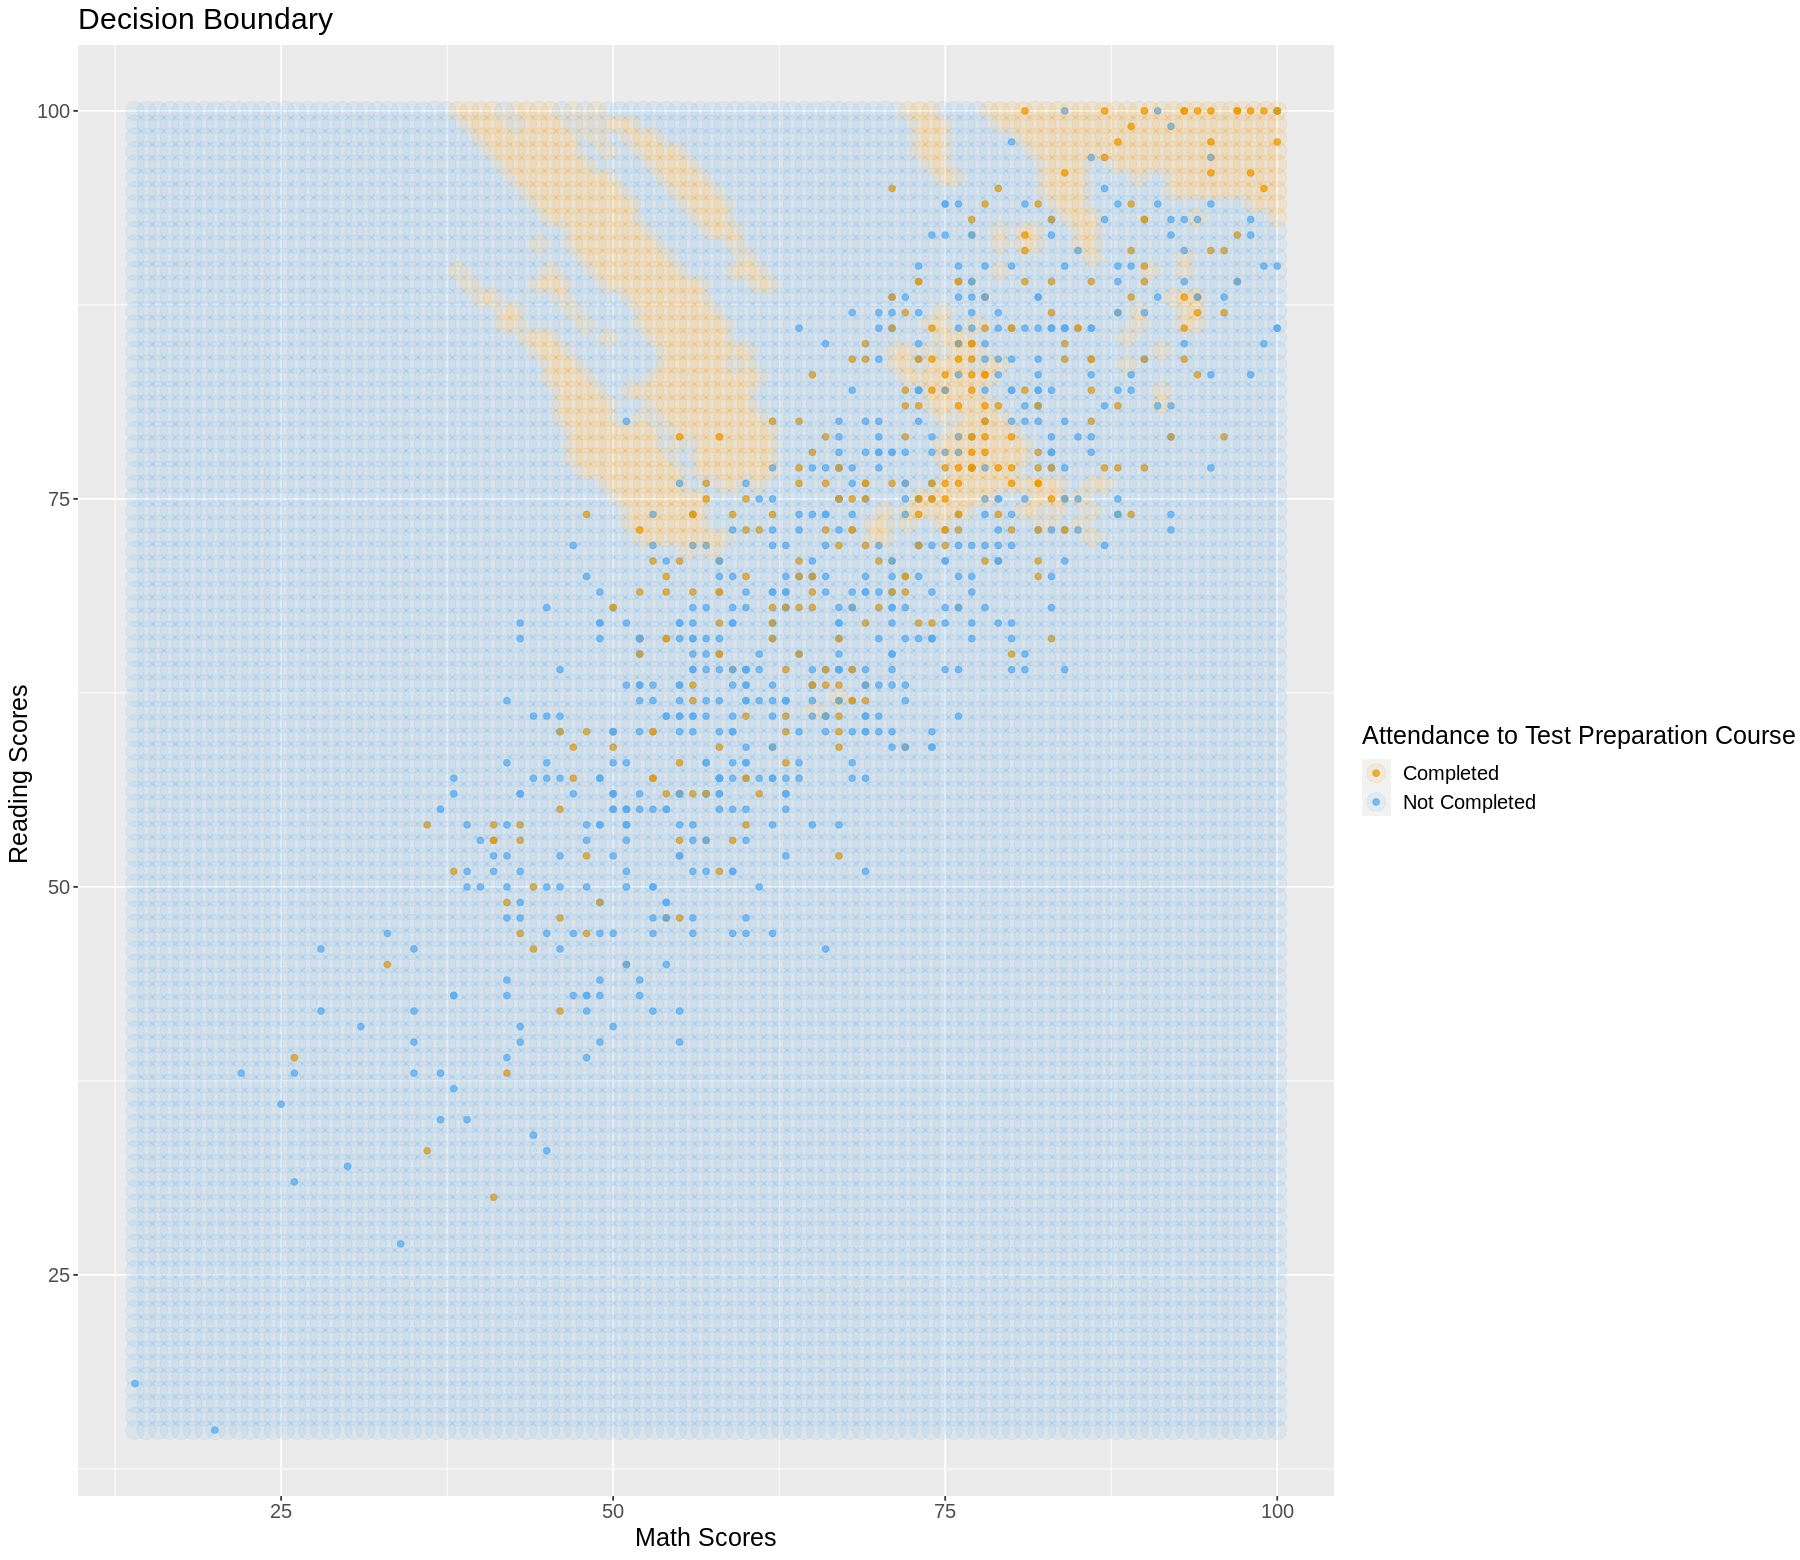

In [66]:
options(repr.plot.width=15, repr.plot.height=13)
wkflw_plot <-
  ggplot() +
  geom_point(data = exam_train, 
             mapping = aes(x = math_score, 
                           y = reading_score, 
                           color = test_preparation_course), 
             alpha = 0.75) +
  geom_point(data = knnPredGrid, 
             mapping = aes(x = math_score, 
                           y = reading_score, 
                           color = test_preparation_course), 
             alpha = 0.1, 
             size = 5) +
  labs(color = "Attendance to Test Preparation Course", 
       x = "Math Scores", 
       y = "Reading Scores ") +
  scale_color_manual(labels = c("Completed", "Not Completed"), 
                     values = c("orange2", "steelblue2"))+
ggtitle("Decision Boundaries")+
theme(text = element_text(size = 15))
wkflw_plot


The `Decision Boundary` graph shows the relationships that exist between our predictor values. As seen above, students who have completed the test preparation course tend to have scored higher than those who have not. This is especially notable in the students reading scores. As you can see the model tends to predict the test prep course as completed when a point lies in the upper left side of the graph. As we saw before there is more distribution in the math score and test prep course attendance. 

In [62]:
#remove this later
#this visuization isn't nessarcy it has taken the decsion boundaries from the graph above and placed it ontop of the 
#testing data 

# wkflw_plot2 <-
#   ggplot() +
#   geom_point(data = exam_test, 
#              mapping = aes(x = reading_score, 
#                            y = math_score, 
#                            color = test_preparation_course), 
#              alpha = 0.75) +
#   geom_point(data = knnPredGrid, 
#              mapping = aes(x = reading_score, 
#                            y = math_score, 
#                            color = test_preparation_course), 
#              alpha = 0.1, 
#              size = 5) +
#   labs(color = "Attendance to Test Preparation Course", 
#        x = "Math Scores", 
#        y = "Writing Scores ") +
#   scale_color_manual(labels = c("Completed", "Not Completed"), 
#                      values = c("orange2", "steelblue2"))

# wkflw_plot2

### Discussion

Our model predicted whether a student attended a test prep course based on their math, reading, writing and average scores. The conclusion drawn from our data analysis was that… ☹ 

Based on previous studies on the topic of test preparation scores, it has been shown that students who had attended test preparation courses received higher scores than those who studied independently (Buchmann et al., 450). Although the increase in scores was not significantly high, it was noticeable enough to improve students’ chances of being admitted into their choice of college (Buchmann et al., 450). This information led us to expect a correlation between high exam scores and the completion of test preparation scores.  

The information extracted from this data analysis is important in determining the effectiveness of the test preparation course in students’ performance. Based on the results of this analysis, future projects could examine the impact of the test preparation courses compared to self-studying methods in students. Other factors that have not been considered in this data set could also be explored. For example, it has been shown that the taking test preparation courses in certain years may be more effective than others when studying for college exams (Devine-Eller, 475). Future studies may be interested in determining the potential benefits and detriments to attending test preparation studies at different periods of a student’s high school career. 


### References

Alon, S. "Commentaries: Racial Differences in Test Preparation Strategies: A Commentary on Shadow Education, American      Style: Test Preparation, the SAT and College Enrollment." *Social Forces*, vol. 89, no. 2, 2010, pp. 463-474.

Devine-Eller, Audrey. “Timing Matters: Test Preparation, Race, and Grade Level.” *Sociological Forum*, vol. 27, no. 2, [Wiley, Springer], 2012, pp. 458–80, http://www.jstor.org/stable/23262117.

Data Source:
http://roycekimmons.com/tools/generated_data/exams



 **Note to Sophie if you see this, we need to cite the source of the data, so please include it when you can (even just the link is fine)**

In [27]:
best_k<-accuracies%>%arrange(desc(mean)) 
head(best_k)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.6948584,5,0.009641087,Model09
10,accuracy,binary,0.6948584,5,0.009641087,Model10
19,accuracy,binary,0.6914572,5,0.006849840,Model19
15,accuracy,binary,0.6903646,5,0.009308906,Model15
16,accuracy,binary,0.6903646,5,0.009308906,Model16
20,accuracy,binary,0.6903461,5,0.006349999,Model20


when picking themost acurate k why was 5 choosen.  

**if having a bad graph we can justify it by us picking a not the most accuate k.**

accuracy is highest of all the k you tried and accuracy is stable so if k goes up or down by one there isn't a drastic change the accuracy is roughly in the same ballpark of numbers for neugbouring k values.

look at k=5 there is some flux in the accuracy of the k values next to it maybe we should have pick k=10? 

## to make decision boundaries visulization of our model we need to use the `contour` function